In [121]:
import numpy as np 
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error


In [122]:
# 1. Fetch Historical Data
start_date = "2024-04-01"
end_date = "2024-10-21"
btc_data = yf.download("BTC-USD", start=start_date, end=end_date, interval="1wk")
btc_data = btc_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [124]:
# 2. Preprocessing
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_data_scaled = scaler.fit_transform(btc_data)

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
        return np.array(X), np.array(y)
        
# Create sequences with a specified window size (e.g., 3 weeks of data to predict the next week)
sequence_length = 3
X, y = create_sequences(btc_data_scaled, sequence_length)

# Reshape X to be suitable for LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
split_fraction = 0.8
split_index = int(len(X) * split_fraction)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [130]:
# 3. Build the LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])



In [131]:
pip install --upgrade tensorflow keras

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/390.3 MB 435.7 kB/s eta 0:14:56
   ---------------------------------------- 0.1/390.3 MB 655.4 kB/s eta 0:09:56
   ---------------------------------------- 0.2/390.3 MB 1.1 MB/s eta 0:05:45
   ---------------------------------------- 0.3/390.3 MB 1.6 MB/s eta 0:04:10
   ---------------------------------------- 0.4/390.3 MB 1.5 MB/s eta 0:04:18
   ---------------------------------------- 0.5/390.3 MB 1.5 MB/s eta 0:04:23
   ---------------------------------------- 0.5/390.3 MB 1.4 MB/s eta 0:04:33
   ---------------------------------------- 0.5/390.3 MB 1.4 MB/s eta 0:04:33
   ---------------------------------------- 0.5/390.3 MB 1.4 MB/s eta 0:04:33
   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.


In [138]:
# 4. Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Epochs:", 50)



X_train shape: (0, 3, 1)
y_train shape: (0,)
Epochs: 50


In [139]:
# 5. Predictions and Evaluation
# Predicting on test set
y_pred = model.predict(X_test)

# Inverse transform predictions and true values to original scale
y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Root Mean Square Error
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
print("RMSE: ", rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
RMSE:  8679.48828125


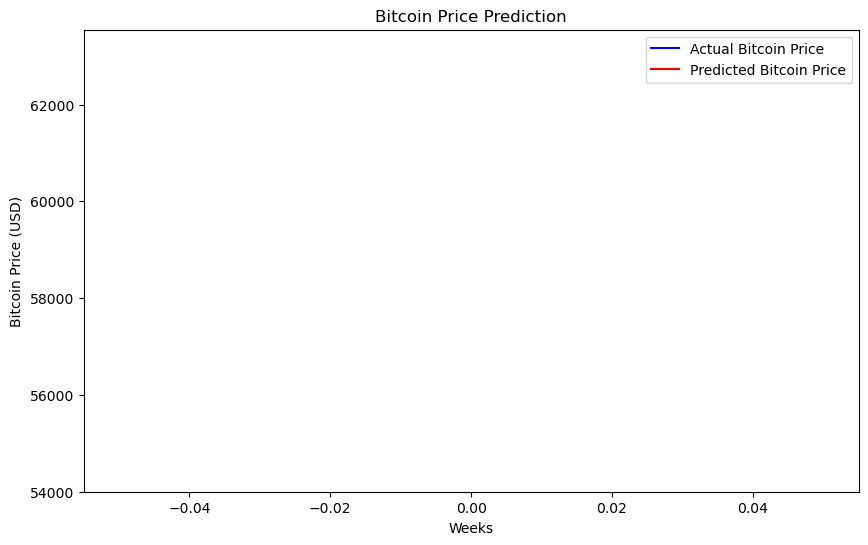

In [140]:
# 6. Plotting the Results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Bitcoin Price')
plt.plot(y_pred_scaled, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Weeks')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


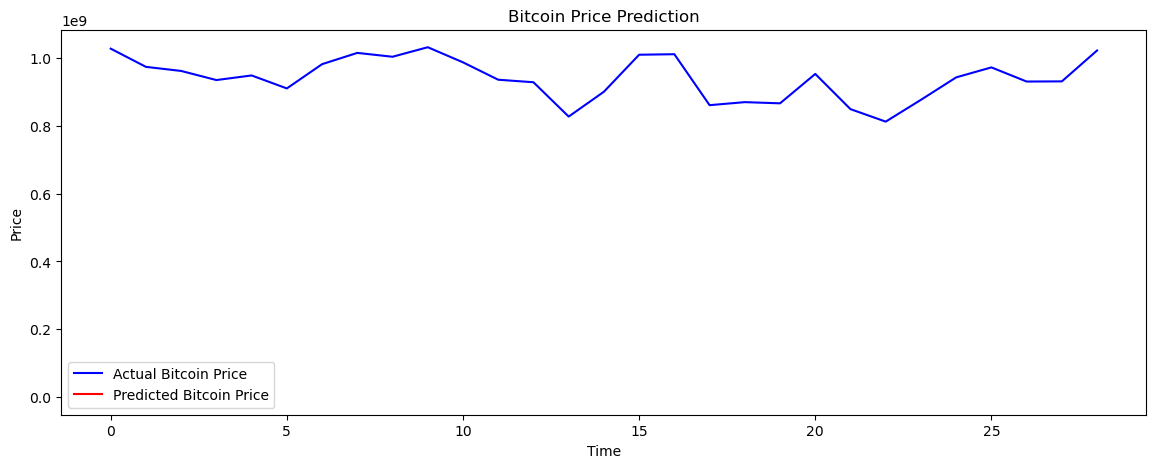

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Future Bitcoin Price Predictions:
Week 1: 54433.7421875
Week 2: 54550.19140625
Week 3: 54682.2109375
Week 4: 54853.21875


In [145]:
# Predict future values
def predict_future(model, last_data, future_steps, scaler):
    predictions = []
    current_data = last_data
    
    for _ in range(future_steps):
        prediction = model.predict(np.reshape(current_data, (1, current_data.shape[0], 1)))
        predictions.append(prediction[0, 0])
        current_data = np.append(current_data[1:], prediction[0, 0])
        current_data = np.reshape(current_data, (current_data.shape[0], 1))
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# Plot the results
def plot_predictions(data, predicted, scaler):
    plt.figure(figsize=(14, 5))
    plt.plot(scaler.inverse_transform(data), color='blue', label='Actual Bitcoin Price')
    plt.plot(range(len(data) - len(predicted), len(data)), scaler.inverse_transform(predicted), color='red', label='Predicted Bitcoin Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
# Make predictions and evaluate
predicted = model.predict(X_test)
plot_predictions(data.values, predicted, scaler)

# Predict future values for the next 4 weeks
future_steps = 4
future_predictions = predict_future(model, X[-1], future_steps, scaler)
print("Future Bitcoin Price Predictions:")
for i, price in enumerate(future_predictions, 1):
    print(f"Week {i}: {price[0]}")
